# Attempt 1: Predicting 'y'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_train_data = pd.read_csv('../data/train.csv')
raw_train_data.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


Seems like we need to predict y, which is just a placeholder for something. This makes it hard for any human judgement on what features could be useful here. It seems we will have to use some code to determine the features to use.

In [3]:
raw_train_data.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [4]:
raw_train_data.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [5]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


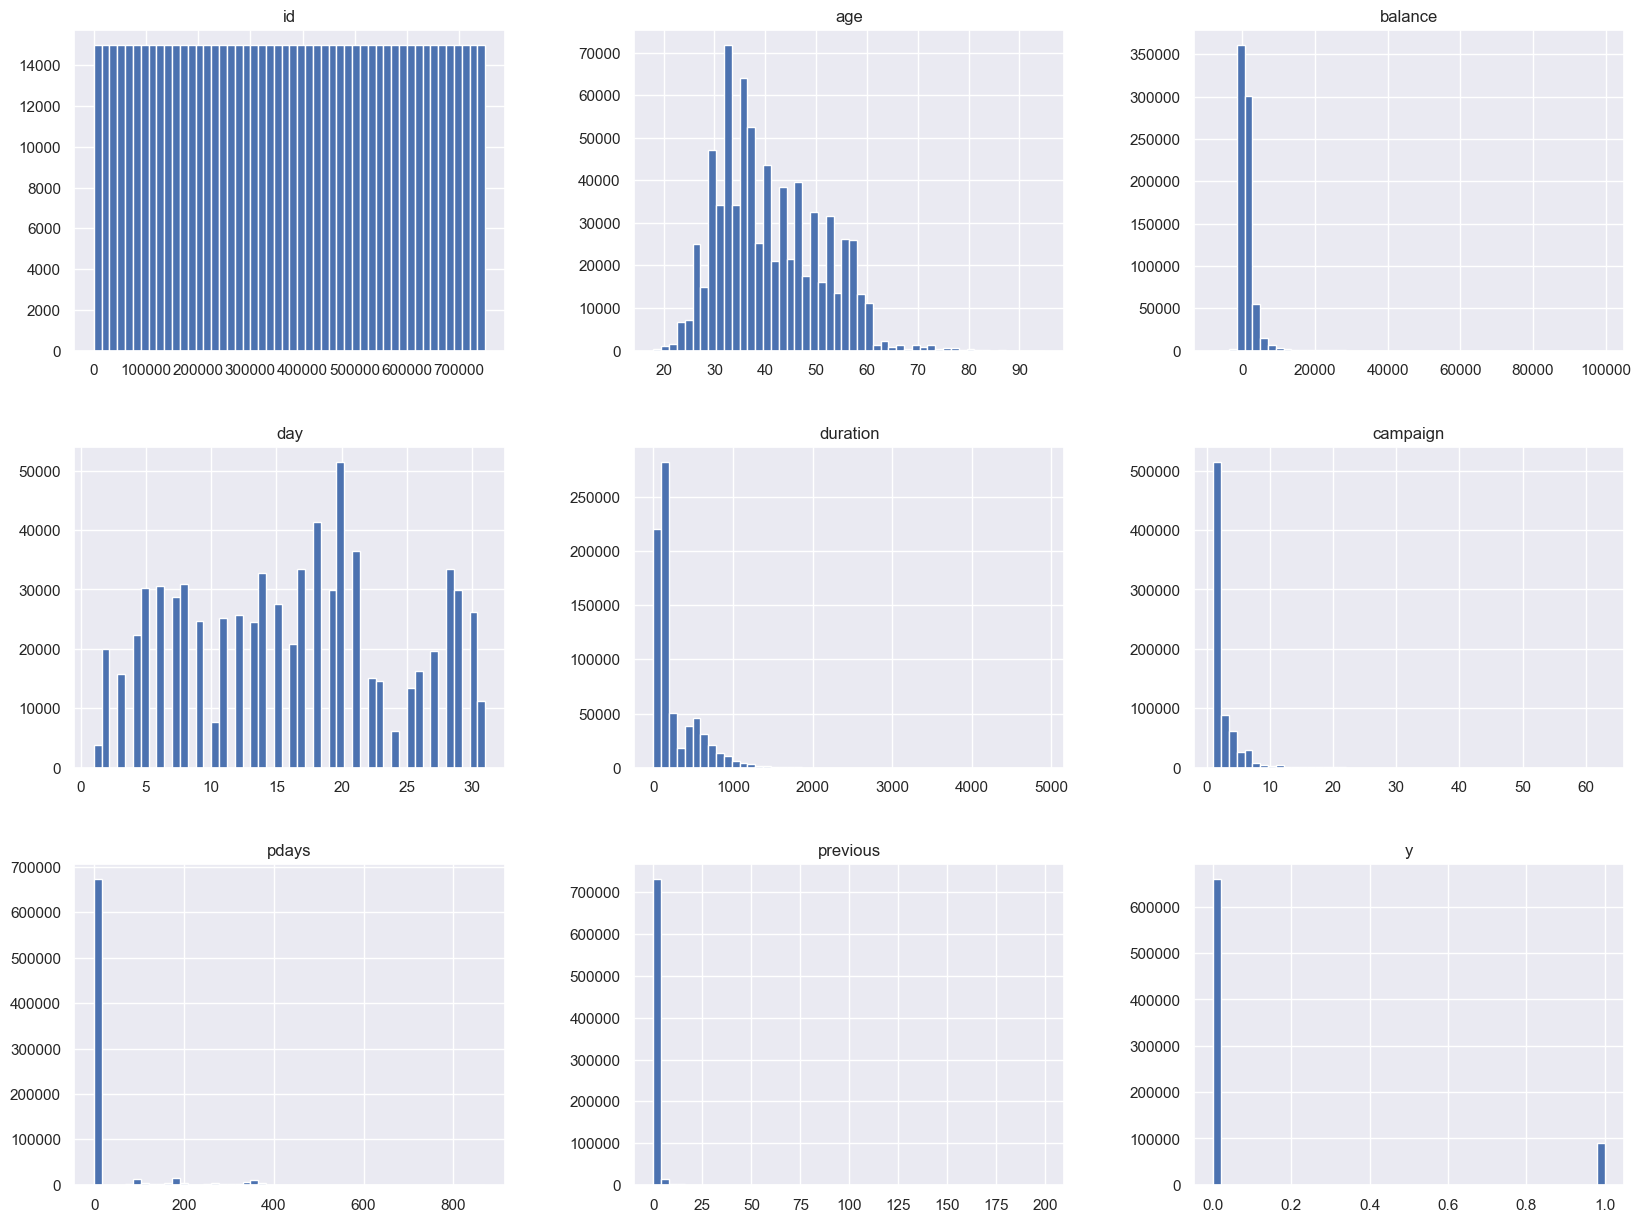

In [6]:
# Let us check the distributions of the numeric values
raw_train_data.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
# A lot of skewed variables here
# Lets also check the correlation:

corr_matrix = raw_train_data.corr(numeric_only=True)
corr_matrix['y'].sort_values(ascending=False)

y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
id          0.000615
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64

Looks like duration is actually the highest correlation for y. Some like ID, age, day and campaign do not seem to be that important. We also know that duration is heavily skewed to the right, so let's engineer some features.

<Axes: >

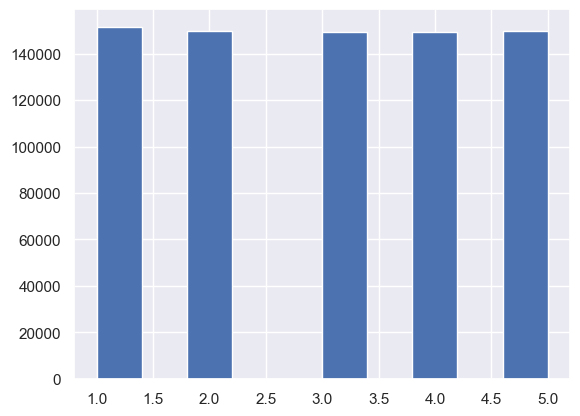

In [8]:
duration_grp = pd.qcut(raw_train_data['duration'], q=5, labels=[1, 2, 3, 4, 5])
duration_grp.hist()

In [9]:
raw_train_data.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [10]:
raw_train_data['job'].value_counts()

job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64

In [11]:
raw_train_data['poutcome'].value_counts()

poutcome
unknown    672450
failure     45115
success     17691
other       14744
Name: count, dtype: int64

Looks good, we have now removed the skew in our best feature. We can further use this to stratify our sample, but for now let's preprocess the categorical values.

In [12]:
from sklearn.preprocessing import LabelEncoder

def data_preprocess(data):
    processed_data = data.drop(['id', 'age', 'day', 'campaign', 'job'], axis=1)
    cat_columns = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
    for col in cat_columns:
        le = LabelEncoder()
        processed_data[col] = le.fit_transform(data[col])
    processed_data['duration_group'] = pd.qcut(data['duration'], q=5, labels=[1, 2, 3, 4, 5])
    return processed_data

In [13]:
prepared_data = data_preprocess(raw_train_data)

In [14]:
prepared_data.head()

,marital,education,default,balance,housing,loan,contact,month,duration,pdays,previous,poutcome,y,duration_group
0,1,1,0,7,0,0,0,1,117,-1,0,3,0,3
1,1,1,0,514,0,0,2,6,185,-1,0,3,0,4
2,1,1,0,602,1,0,2,8,111,-1,0,3,0,2
3,2,1,0,34,1,0,2,8,10,-1,0,3,0,1
4,1,1,0,889,1,0,0,3,902,-1,0,3,1,5


In [15]:
from sklearn.model_selection import train_test_split

y = prepared_data['y']
X = prepared_data.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=prepared_data['duration_group'], random_state=42)

## Training the model

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
from sklearn.metrics import roc_auc_score

def display_roc_auc(model):
    predictions = model.predict_proba(X_train)[:, 1]
    print(roc_auc_score(y_train, predictions))

def display_roc_auc_test(model):
    predictions = model.predict_proba(X_test)[:, 1]
    print(roc_auc_score(y_test, predictions))

In [18]:
display_roc_auc(log_reg)
display_roc_auc_test(log_reg)

0.9068335473810635
0.9077756136051189


Woah what the hell? This actually looks like a good model. Let's try submitting this.

In [19]:
def write_submission_csv(model, filename="../submissions/submission.csv"):
    test_raw = pd.read_csv('../data/test.csv')
    ids = test_raw['id']
    test_prep = data_preprocess(test_raw)
    predictions = model.predict_proba(test_prep)[:, 1]

    submission_df = pd.DataFrame({
        "id": ids,
        "y": predictions,
    })
    submission_df.to_csv(filename, index=False)

In [20]:
write_submission_csv(log_reg)

Ok, looks like I got too excited. Majority of the submissions have 90% and above for their submissions, so it's time I move onto better feature engineering and model selection.

In [ ]:
# First of all, lets update our data preprocess function
from sklearn.preprocessing import OrdinalEncoder

def data_preprocess(data, model_type="tree"):
    # Drop irrelevant columns
    processed_data = data.drop(['id', 'age', 'day', 'campaign', 'job'], axis=1)
    
    # Categorical columns
    cat_columns = ['marital', 'education', 'default', 'housing', 'loan',
                   'contact', 'month', 'poutcome']
    
    if model_type == "linear":
        # Encode categories for linear models
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        processed_data[cat_columns] = encoder.fit_transform(processed_data[cat_columns])
    
    processed_data['duration_group'] = pd.qcut(
        processed_data['duration'], q=5, labels=False
    ) + 1
    processed_data = processed_data.drop(columns=['duration'])
    
    return processed_data

In [22]:
from catboost import CatBoostClassifier

prepared_data = data_preprocess(raw_train_data)
y = prepared_data['y']
X = prepared_data.drop('y', axis=1)

cat_columns = ['marital', 'education', 'default', 'housing', 'loan', 
               'contact', 'month', 'poutcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_columns,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	test: 0.9187510	best: 0.9187510 (0)	total: 142ms	remaining: 1m 11s
100:	test: 0.9573049	best: 0.9573049 (100)	total: 7.2s	remaining: 28.5s
200:	test: 0.9589550	best: 0.9589550 (200)	total: 14.9s	remaining: 22.2s
300:	test: 0.9600165	best: 0.9600165 (300)	total: 22.2s	remaining: 14.7s
400:	test: 0.9606220	best: 0.9606220 (400)	total: 29.6s	remaining: 7.32s
499:	test: 0.9610119	best: 0.9610119 (499)	total: 37.1s	remaining: 0us

bestTest = 0.9610119045
bestIteration = 499



In [24]:
display_roc_auc(cat_model)
display_roc_auc_test(cat_model)

0.9619126052763289
0.9610119044871215


Woah this looks even better! Let's try submitting this.

In [25]:
write_submission_csv(cat_model, filename="../submissions/submission2.csv")